In [3]:
from azureml.core.run import Run

import argparse
import os
import numpy as np

from azureml.core import Run

import numpy as np
#import panda as pd

run = Run.get_context()

In [4]:

def download_data(download_url,dataset_name):
    """Download and extract the training data."""
    import urllib
    # download data
    data_file = dataset_name+'.csv'
    urllib.request.urlretrieve(download_url, filename=data_file)

  
    return data_file

In [5]:

def load_data(download_url,split_random_seeds):
    filename = os.path.join(os.getcwd(),download_url)
    print(filename)
    import pandas as pd
    df = pd.read_csv(filename)
    x_df = df.drop(columns =['target'])
    y_df = df[['target']]

    #import azureml.dataprep as dprep
    #raw_data = dprep.read_csv(path=download_url, header=dprep.PromoteHeadersMode.GROUPED)
    #type_infer = raw_data.builders.set_column_types()
    #type_infer.learn()
    #type_converted_df = type_infer.to_dataflow()
    #dflow_prepared=type_converted_df
    #dflow_X = dflow_prepared.drop_columns('target')
    #dflow_y = dflow_prepared.keep_columns('target')
    #x_df = dflow_X.to_pandas_dataframe()
    #y_df = dflow_y.to_pandas_dataframe()
    from sklearn.model_selection import train_test_split
    
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.4, random_state=split_random_seeds)
    # flatten y_train to 1d array
    y_train.values.flatten()
    return x_train, x_test, y_train, y_test

In [6]:

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--split_random_seeds', type=int, dest = 'split_random_seeds', help='Seed')
parser.add_argument('--data_download_url', type=str, dest = 'data_download_url', help='Url')
parser.add_argument('--dataset_name', type=int, dest = 'dataset_name', help='dataset_name')

parser.add_argument('--max_depth', type=int, dest = 'max_depth', help='max_depth')
parser.add_argument('--eta', type=int, dest = 'eta', help='eta')
parser.add_argument('--silent', type=int, dest = 'silent', help='silent')
args = parser.parse_args()


usage: ipykernel_launcher.py [-h] [--split_random_seeds SPLIT_RANDOM_SEEDS]
                             [--data_download_url DATA_DOWNLOAD_URL]
                             [--dataset_name DATASET_NAME]
                             [--max_depth MAX_DEPTH] [--eta ETA]
                             [--silent SILENT]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/local/SAIL/jzhou/.local/share/jupyter/runtime/kernel-665ee878-4fcb-4360-975d-6b36c41c7ea7.json


SystemExit: 2

/home/local/SAIL/jzhou/anaconda3/envs/automl_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
# MOCK
class args:
    data_download_url = "https://workspacefresh8433893662.blob.core.windows.net/azureml/defect_eclipse_2_0.csv",
    split_random_seeds = 42
    dataset_name = 'defect_eclipse_2_0'
    output_dir = './outputs'

args.data_download_url = "https://raw.githubusercontent.com/yiikou/AML_vs_HPT/master/data/defect_eclipse_2_0.csv"
args.split_random_seeds = 42
args.dataset_name='defect_eclipse_2_0'
args.output_dir = './outputs'

In [9]:
data_local_path= download_data(args.data_download_url,args.dataset_name)
#data_local_path

x_train, x_test, y_train, y_test = load_data(data_local_path,args.split_random_seeds)

/home/local/SAIL/jzhou/AML_vs_HPT/defect_eclipse_2_0.csv


In [46]:
int(y_test.shape[0]*0.1)

269

In [20]:
#xgb_param = {'max_depth':args.max_depth, 'eta':args.eta, 'silent':args.silent, 'objective':'binary:logistic' }
xgb_param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' 
             ,'num_boost_round':1000
            }


In [21]:
print(str(xgb_param))

{'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic', 'num_boost_round': 1000}


In [12]:

clf = xgb.XGBClassifier(**xgb_param)


In [88]:

from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=42)


In [98]:

from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer
auc_weighted_all=cross_val_score(clf, x_train, y_train.values.flatten(), cv=cv,scoring=make_scorer(roc_auc_score, average='weighted',needs_threshold=True))  

In [100]:
mean(auc_weighted_all)

0.8407454273474563

In [101]:
cross_val_score(clf, x_train, y_train.values.flatten(), cv=2,scoring=make_scorer(roc_auc_score, average='weighted',needs_threshold=True))  

array([0.84312315, 0.822727  ])

In [97]:
from statistics import *

median(auc_weighted_all)

0.6089906713736866

In [84]:
for rs_train,rs_test in cv.split(x_train):
    rs_train,rs_test

In [85]:
y_train.iloc[rs_train].values.flatten()
y_train.iloc[rs_test].values.flatten()

array([False, False, False, ..., False, False,  True])

In [87]:

#xgb_model =clf.fit(x_train, y_train.values.flatten())



xgb_model =clf.fit(x_train.iloc[rs_train], y_train.iloc[rs_train].values.flatten())

from sklearn.metrics import auc,accuracy_score,roc_auc_score,auc,roc_curve
predicted_training_y = xgb_model.predict_proba(x_train.iloc[rs_test])
training_auc_weighted=roc_auc_score(y_train.iloc[rs_test].values.flatten(),predicted_training_y[:,1],average='weighted')
if training_auc_weighted < 0.5: 
    training_auc_weighted = 1-training_auc_weighted
training_auc_weighted

0.8326841409567736

In [33]:
from sklearn.linear_model import LogisticRegression
#hyper_param = {"random_state":1}
clf = LogisticRegression()
clf.fit(x_train, y_train)

/home/local/SAIL/jzhou/anaconda3/envs/automl_env/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/local/SAIL/jzhou/anaconda3/envs/automl_env/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
import xgboost as xgb
print(xgb.__version__)
#clf = xgb.XGBModel(**param_dist)
clf = xgb.XGBClassifier(**xgb_param)

xgb_model =clf.fit(x_train, y_train,
        eval_set=[(x_train, y_train)],
        eval_metric=['auc']
        #eval_metric=['auc','logloss','rmse','mae','error'],
        #verbose=True
                  )


vals_result = xgb_model.evals_result()

0.90


TypeError: fit() got an unexpected keyword argument 'num_boost_round'

In [41]:
#%%capture cap --no-stderr

import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clf).fit(x_test, y_test.values)
o2 = (eli5.show_weights(perm,feature_names  = x_test.columns.tolist()))

#with open('output.txt', 'w') as f:
#    f.write(cap.stdout)

In [54]:
from IPython.display import display, HTML
display(HTML("<h1>o1</h1>"+o1.data+"<h1>o2</h1>"+o2.data))

Weight,Feature
0.1147 ± 0.0073,MLOC_sum
0.1060 ± 0.0049,NBD_sum
0.0334 ± 0.0023,TLOC
0.0311 ± 0.0046,pre
0.0287 ± 0.0066,PAR_sum
0.0174 ± 0.0039,CC_max
0.0162 ± 0.0052,NOM_avg
0.0068 ± 0.0038,NOM_max
0.0061 ± 0.0038,MLOC_avg
0.0059 ± 0.0043,NSF_avg


In [52]:
o1.url

In [65]:

validated_auc=    vals_result['validation_0']['auc']
len(validated_auc)//2

50

In [69]:
validated_auc[-10:]


[0.875447,
 0.8755,
 0.875719,
 0.875878,
 0.875878,
 0.875821,
 0.875909,
 0.875988,
 0.876272,
 0.876524]

In [9]:
from sklearn.metrics import auc,accuracy_score,roc_auc_score,auc,roc_curve

predicted_training_y = xgb_model.predict_proba(x_train)
#predicted_training_y
training_auc_weighted=roc_auc_score(y_train,predicted_training_y[:,1],average='weighted')
if training_auc_weighted < 0.5: training_auc_weighted = 1-training_auc_weighted
training_auc_weighted

0.8765241761372757

In [10]:
run_logger.log("auc_weighted", float(training_auc_weighted))


NameError: name 'run_logger' is not defined

In [35]:
import os
import pickle
os.makedirs(args.output_dir, exist_ok=True)

pickle.dump(xgb_model, open(os.path.join(args.output_dir, 'model.pt'), 'wb'))

In [10]:
from sklearn.externals import joblib
joblib.dump(value=xgb_model, filename = os.path.join(args.output_dir, 'model.pkl'))

['./outputs/model.pkl']

In [11]:
os.path.join(args.output_dir, 'model.pkl')

'./outputs/model.pkl'

In [12]:
joblib.load(os.path.join(args.output_dir, 'model.pkl'))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1, subsample=1)

In [1]:
# Test

import xgboost as xgb

clf = xgb.XGBClassifier(objective = 'binary:logistic',
                        base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bytree=0.6, eta=0.1, gamma=5, learning_rate=0.1,
          max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
          missing=None, n_estimators=800, n_jobs=1, nthread=None, random_state=0,
          reg_alpha=0.5208333333333334, reg_lambda=0.7291666666666667,
          scale_pos_weight=1, seed=None, silent=True, subsample=0.6,
          tree_method='auto', verbose=-10)

xgb_model =clf.fit(x_train, y_train,
        eval_set=[(x_train, y_train)],
        eval_metric=['auc'],
        #eval_metric=['auc','logloss','rmse','mae','error'],
        #verbose=True
                  )

NameError: name 'x_train' is not defined

In [19]:
from sklearn.metrics import auc,accuracy_score,roc_auc_score,auc,roc_curve
from sklearn.utils import resample
sample_size = int(y_test.shape[0]*0.1)
boot_size = 100
auc_weighted_list=[]
for ite in range(1,boot_size):
    resample_x, resampel_y = resample(x_test,y_test
                                      #, n_samples=sample_size
                                      , replace=True, 
          random_state=ite)
    predicted_y = xgb_model.predict_proba(resample_x)
    auc_weighted=roc_auc_score(resampel_y,predicted_y[:,1],average='weighted')
    if auc_weighted < 0.5: 
        auc_weighted = 1-auc_weighted
    auc_weighted_list.append(auc_weighted)

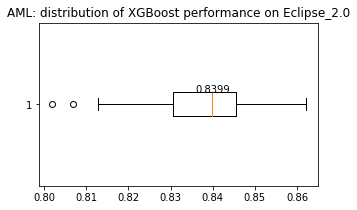

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
plt.rcParams["figure.figsize"] = (5, 3)
fig1, ax1 = plt.subplots()
ax1.set_title('AML: distribution of XGBoost performance on Eclipse_2.0')
bp_dict = ax1.boxplot(auc_weighted_list,vert=False)
for line in bp_dict['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    text(x, y, round(x,4),
         horizontalalignment='center') # draw above, centered


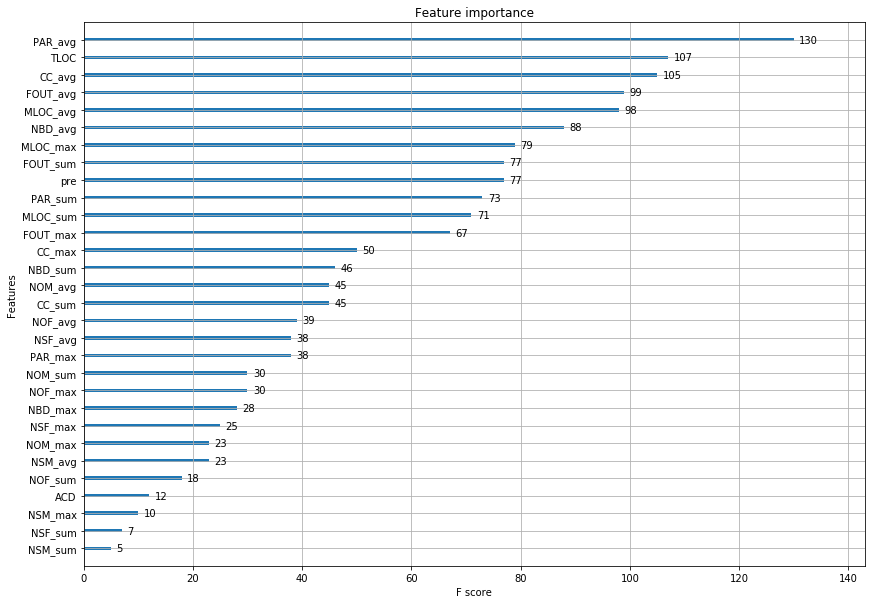

In [23]:
from xgboost import plot_importance
from matplotlib import pyplot as plt

#fig2, ax2 = plt.subplots(1,1,figsize=5)
plt.rcParams["figure.figsize"] = (14, 10)
plot_importance(xgb_model)
plt.show()